In [2]:
import sys, getopt
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import time
sys.path.append('../neural_networks/mnist_cnn')
sys.path.append('../neural_networks/mnist_gan')
sys.path.append('../neural_networks/mnist_wgan')
import mnistCnn
import mnistGan
import wgan
import targetFunction

In [3]:
(X_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_data = X_train.copy()
img_data = img_data.reshape(X_train.shape[0], 28, 28, 1)
img_data = img_data / 255 #pixel values in [0,1]
#print(img_data.shape)
test_data = x_test.copy()
test_data = test_data.reshape(x_test.shape[0], 28, 28, 1)
test_data = test_data / 255
#print(test_data.shape)
y_test_one_hot = np.eye(10)[y_test]

In [4]:
cnn = mnistCnn.MnistCnn()
cnn.loadWeights('../neural_networks/mnist_cnn/largerCnn30Epochs')
genPath = '../neural_networks/mnist_gan/NewMnistGan200Epochs/mnist_gen'
discPath = '../neural_networks/mnist_gan/NewMnistGan200Epochs/mnist_disc'
gan = mnistGan.MnistGan()
gan.loadWeights(genPath, discPath)

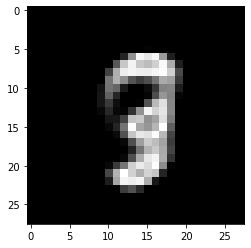

In [5]:
err = 1e-16
x_median = np.median(test_data, axis=0)
x_0 = test_data[0]
MAD = np.median(np.abs(test_data - x_median), axis = 0)
MAD_tf = tf.constant(tf.cast(np.expand_dims(MAD, 0), tf.float32))
mask = tf.equal(MAD_tf, 0.0)
MAD_tf_err = tf.where(mask, tf.fill(MAD_tf.shape, err), MAD_tf)
plt.imshow(MAD, cmap = 'gray', interpolation = 'none')

In [6]:
def explainer(x, targetIndex, maxIter = 600, epsilon = 0.1, err = 1e-16, normConstraint = 'none', objective = 'loss', distance = 'l1', from_random = False):
    closeEnough = False
    iter = 0
    xOld = x
    xNew = tf.Variable(tf.identity(x))
    if(from_random):
        xNew = tf.Variable(tf.cast(np.expand_dims(np.expand_dims(np.random.rand(28,28), -1), 0), tf.float32))
    targetFunc = targetFunction.TargetFunction(classifier = cnn.model, targetIndex = targetIndex, objective = objective, distance = distance, discriminator = gan.discriminator, MAD = MAD_tf_err)
    while(not closeEnough and iter < maxIter):
        with tf.GradientTape() as tape:
                res = targetFunc.apply(xNew, xOld)
        grad = tape.gradient(res, xNew)
        xNew.assign(xNew + grad)
        xNew.assign(tf.clip_by_value(xNew, clip_value_min = 0, clip_value_max = 1))
        iter += 1
        newIndex = tf.argmax(tf.squeeze(cnn.model(xNew))).numpy()
        if(targetIndex == newIndex):
            closeEnough = True
    print(iter)
    return xNew

In [7]:
def explainWithAdam(x, targetIndex, objective = 'loss', distance = 'l1'):
    xOld = x
    xNew = tf.Variable(tf.identity(x))
    targetFunc = targetFunction.TargetFunction(classifier = cnn.model, targetIndex = targetIndex, objective = objective, distance = distance, discriminator = gan.discriminator)
    adam = tf.keras.optimizers.Adam()
    adam.minimize(targetFunc.apply, xNew)
    return xNew

4


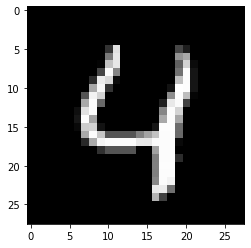

In [8]:
x_test1 = tf.Variable(tf.cast(np.expand_dims(test_data[4],0), tf.float32))
y_test1 = y_test[4]
print(y_test1)
plt.imshow(x_test1[0,:,:,0], cmap = 'gray', interpolation = 'none')

4
5
1000
1000
1000
1000
1000
1000
2
9


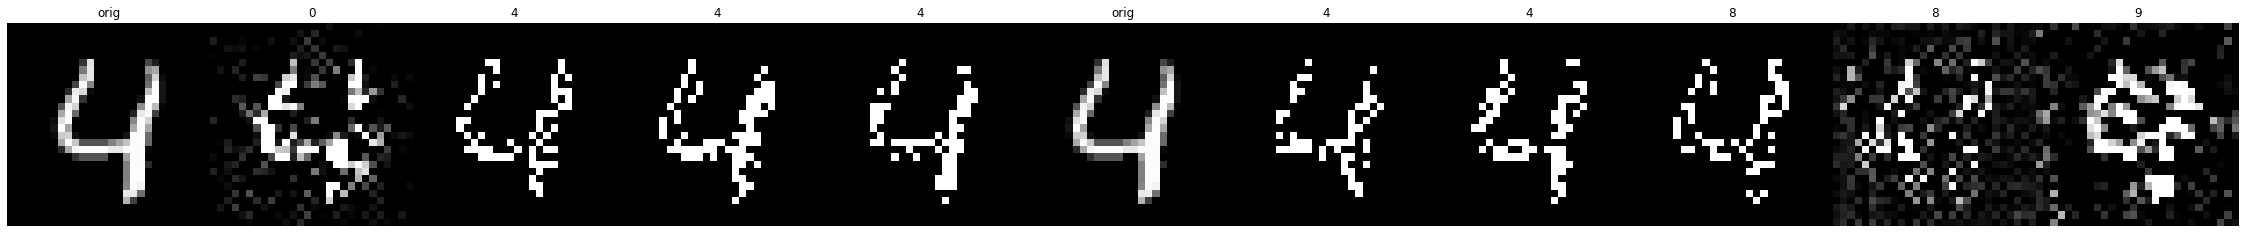

In [9]:
norm = colors.Normalize(vmin = 0, vmax = 1)
fig, ax = plt.subplots(1, 11, sharey = False, figsize = (40, 400))
print(y_test1)
ax[0].imshow(x_test1[0,:,:,0], cmap = 'gray', interpolation = 'none')
ax[0].set_title('orig')
ax[0].axis('off')
for i in range(10):
    if(y_test1 == i):
        ax[i+1].imshow(x_test1[0,:,:,0], cmap = 'gray', interpolation = 'none')
        ax[i+1].set_title('orig')
        ax[i+1].axis('off')
        continue
    explanation = explainer(x = x_test1, targetIndex = i, maxIter = 1000, epsilon = 0.01, from_random = True)
    tempImg = ax[i+1].imshow(explanation[0,:,:,0], cmap = 'gray', interpolation = 'none')
    pred = tf.argmax(tf.squeeze(cnn.model(explanation))).numpy()
    ax[i+1].set_title(str(pred))
    tempImg.set_norm(norm)
    ax[i+1].axis('off')
plt.subplots_adjust(wspace = 0.0, hspace = 0.4)

4
185
1000
1000
1000
1000
1000
1000
4
77


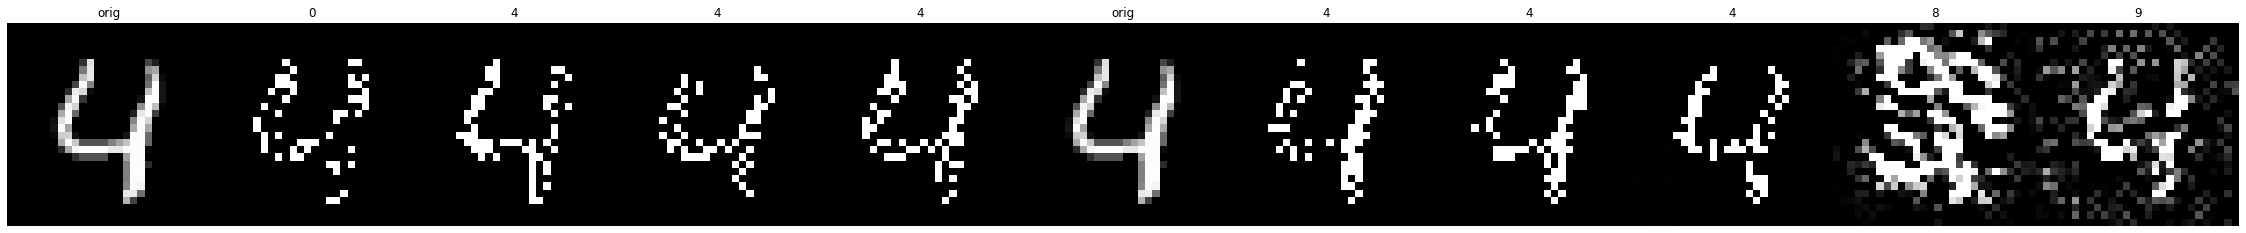

In [10]:
norm = colors.Normalize(vmin = 0, vmax = 1)
fig, ax = plt.subplots(1, 11, sharey = False, figsize = (40, 400))
y_test1 = y_test[4]
print(y_test1)
ax[0].imshow(x_test1[0,:,:,0], cmap = 'gray', interpolation = 'none')
ax[0].set_title('orig')
ax[0].axis('off')
for i in range(10):
    if(y_test1 == i):
        ax[i+1].imshow(x_test1[0,:,:,0], cmap = 'gray', interpolation = 'none')
        ax[i+1].set_title('orig')
        ax[i+1].axis('off')
        continue
    explanation = explainer(x = x_test1, targetIndex = i, maxIter = 1000, epsilon = 0.01)
    tempImg = ax[i+1].imshow(explanation[0,:,:,0], cmap = 'gray', interpolation = 'none')
    pred = tf.argmax(tf.squeeze(cnn.model(explanation))).numpy()
    ax[i+1].set_title(str(pred))
    tempImg.set_norm(norm)
    ax[i+1].axis('off')
plt.subplots_adjust(wspace = 0.0, hspace = 0.4)

1000
1000
1000
1000
1000
1000
1000
3
1000


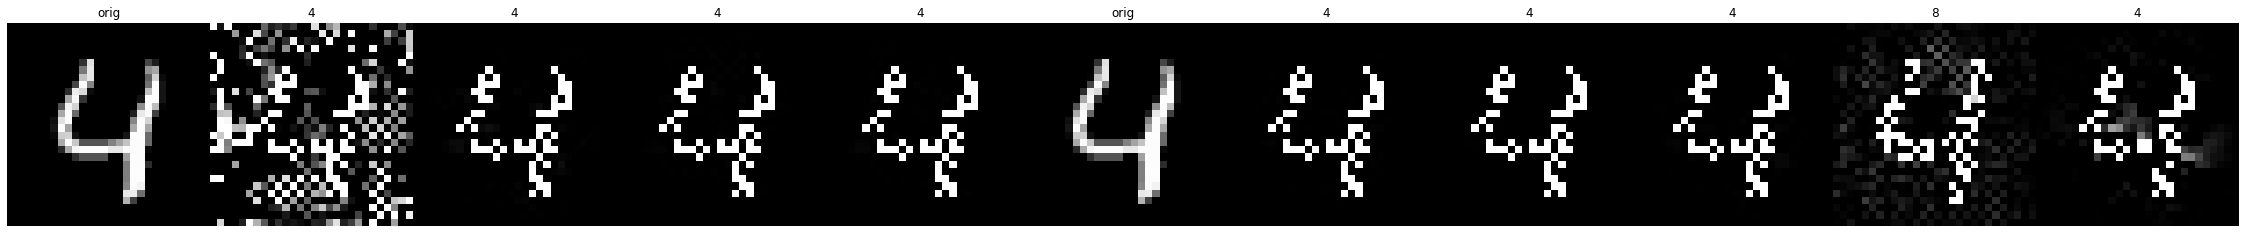

In [11]:
norm = colors.Normalize(vmin = 0, vmax = 1)
fig, ax = plt.subplots(1, 11, sharey = False, figsize = (40, 400))
ax[0].imshow(x_test1[0,:,:,0], cmap = 'gray', interpolation = 'none')
ax[0].set_title('orig')
ax[0].axis('off')
for i in range(10):
    if(y_test1 == i):
        ax[i+1].imshow(x_test1[0,:,:,0], cmap = 'gray', interpolation = 'none')
        ax[i+1].set_title('orig')
        ax[i+1].axis('off')
        continue
    explanation = explainer(x = x_test1, targetIndex = i, maxIter = 1000, epsilon = 0.01, distance = 'l1MAD')
    tempImg = ax[i+1].imshow(explanation[0,:,:,0], cmap = 'gray', interpolation = 'none')
    pred = tf.argmax(tf.squeeze(cnn.model(explanation))).numpy()
    ax[i+1].set_title(str(pred))
    tempImg.set_norm(norm)
    ax[i+1].axis('off')
plt.subplots_adjust(wspace = 0.0, hspace = 0.4)